In [43]:
# -*- coding: utf-8 -*-
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
from sklearn.cluster import KMeans 
os.chdir(r"C:\Users\WanShenghua\Documents\codes")

D:\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Python37\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
D:\Python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [109]:
def loadDataset(year,area):
    img=cv2.imread(r"E:\project\images\researchImage\images\cut\\"+year+"\\"+area+".tif")
    imgre=np.reshape(img,(-1,3))
    return imgre

In [110]:
def zmean(data):
    mu=np.mean(data,axis=0,keepdims=True)
    std=np.std(data,axis=0,keepdims=True)
    return (data-mu)/std

In [54]:
def splitC(data,label,k):
    data=data.copy().reshape(-1,3)
    label=label.reshape(-1,1)
    mer=np.concatenate((data,label),axis=1)
    c0=mer[mer[:,3]==0][:,:-1]
    c1=mer[mer[:,3]==1][:,:-1]
    c2=mer[mer[:,3]==2][:,:-1]
    c3=mer[mer[:,3]==3][:,:-1]
    #c4=mer[mer[:,3]==4][:,:-1]
    c=[c0,c1,c2,c3]
    mu=np.zeros((k,3))
    R=np.zeros((k),dtype=np.float64)
    for i in range(k):
        mu[i,:]=np.mean(c[i],axis=0)
        R[i]=c[i].shape[0]/data.shape[0]
    dist=np.zeros(data.shape[0],dtype=np.float64)
    for i in range(data.shape[0]):
        dist[i]=distance(mer[i,:3],mu[mer[i,3]])
    return c,mu,dist,R

In [55]:
label=cv2.imread(r"E:\project\images\researchImage\images\cut\label\17_7_10.tif",0)
data=cv2.imread(r"E:\project\images\researchImage\images\cut\15\7_10.tif")

In [56]:
c,mu,dist,R=splitC(data,label,4)

In [57]:
dataReshape=data.reshape((-1,3))

In [58]:
R

array([0.41438293, 0.08494568, 0.2820282 , 0.21864319])

In [59]:
# kmeans
# 定义距离
def distance(nums1,nums2):
    return np.sqrt(np.sum((nums1-nums2)**2))
# kmeans分类器
def kmeans(dataset,k,centroid,dist,Rbefore,m,maxIterationNum=200):
    # 2.1 定义相关变量
    resultList = []                         # 定义变量存储结果
    numSample, dim = dataset.shape
    ##print(dataset.shape)
    # 存放每一像元的归属类别标签和到该类的距离
    clusterAssment = np.zeros((numSample, 2), dtype = np.float64) 
    clusterFlag = True            # 类别标记，判断迭代是否继续
    numIteration = 0                 # 迭代次数
    # 2.3 设定初始距离
    clusterAssment[:, 1] = dist.reshape((-1,))
    r=np.zeros((k),dtype=np.float64)
    r=Rbefore
    print("clusterAssment1:",clusterAssment)
    # 2.4 聚类
    while(clusterFlag):
        # 2.4.1 复制上一次聚类结果
        clusterAssmentBefore = clusterAssment.copy()
        rBefore = r.copy() 
        # 2.4.2 迭代次数判断
        numIteration += 1
        if(numIteration > maxIterationNum):
            break                  # 如果迭代次数超过指定次数，跳出循环
        print('第%s次迭代中...' % numIteration)
        # 2.4.3 更改循环判别条件为不循环，如果下文条件允许循环则再次更改为True
        clusterFlag = False
        # 2.4.4 循环聚类
        for i in range(numSample):       # 遍历每个像元
            # 2.4.4.2 距离计算
            disArray=np.zeros((k),dtype=np.float64)
            for j in range(k):
                # 逐一计算每一像元与各类中心的距离
                disArray[j] = distance(dataset[i, :], centroid[j,:])              
            # 如果与某一类别中心的距离较小，则判定像元属于该类别
            minDist = np.min(disArray)
            minIndex = np.argmin(disArray)
            # 2.4.4.3 判别
            if(clusterAssment[i, 0] != minIndex):  # 改变类中心距离并执行下次迭代
                clusterFlag = True
                clusterAssment[i, :] = minIndex, minDist ** 2
        # 比例计算
        sums=dataset.shape[0]
        for i in range(1,k):
            r[i]=np.sum(clusterAssment[:,0]==i)/sums
        # 2.4.5 判断是否收敛,只计数非0类
        # print(clusterAssment[clusterAssment[:,0]!=0])
        errorAfter = np.sum(clusterAssment[clusterAssment[:,0]!=0][:,1])*(1+np.sum((r-Rbefore)**2))   # 上次迭代损失
        errorBefore = np.sum(clusterAssmentBefore[clusterAssmentBefore[:,0]!=0][:, 1])*(1+np.sum((rBefore-Rbefore)**2))   # 本次迭代损失
        print("errorBefore",errorBefore)
        print("errorAfter:",errorAfter)
        if(errorAfter <= errorBefore):                         # 结果发散，舍弃本次
            return resultList
        # 2.4.6 重新计算类别中心
        labelMat = clusterAssment[:, 0]                     # 取出第一列(类别标签)
        ##print(labelMat)
        for cent in range(k):                               # 针对每个类别重新计算
            ##print(labelMat == cent)
            temp = dataset[labelMat == cent]                # 分别选取属于每一类的像元
            ##print(temp)
            centroid[cent, :] = np.mean(temp, axis = 0)     # 计算本类别新的中心
        # 2.4.7 将最后一次计算结果添加到结果列表中
        resultList.append((centroid.copy(), clusterAssment.copy()))
    return resultList

In [60]:
resultList = kmeans(dataReshape, 4, mu,dist,R,10000000,100)

clusterAssment1: [[ 0.         19.41470401]
 [ 0.         17.683458  ]
 [ 0.         24.60912162]
 ...
 [ 0.          9.50754806]
 [ 0.         12.33949569]
 [ 0.          3.9130103 ]]
第1次迭代中...
errorBefore 0.0
errorAfter: 91020754.71638605
第2次迭代中...
errorBefore 94192863.84900714
errorAfter: 92143279.19016416


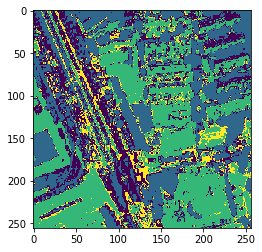

In [61]:
##第三步：显示结果
rows,cols,_=data.shape
res = np.zeros((data.shape[0]*data.shape[1]))
cmap = [0, 1, 2, 3, 4]      # 定义颜色
##print(resultList)              # 取出每次迭代的结果
res = resultList[0][-1][:,0].reshape((rows, cols)) 
cv2.imwrite(r"E:\project\images\researchImage\predict\kmeans15_7_10_norm.tif",res*50)
plt.imshow(res*50)   

D:\Python37\lib\site-packages\sklearn\cluster\k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


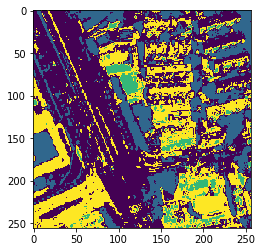

In [62]:
imgre=np.reshape(data,(-1,3))
estimator = KMeans(n_clusters=4,init=mu)#构造聚类器
estimator.fit(imgre)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和
pred=np.reshape(label_pred,(256,256))
#plt.subplot(121)
cv2.imwrite(r"E:\project\images\researchImage\predict\K_Means15_7_10.tif",pred)
plt.imshow(pred)
#plt.subplot(122)
#plt.imshow(img)

In [127]:
resultList[0][-1]

array([[  1.        , 710.2103783 ],
       [  1.        , 333.89419568],
       [  1.        , 225.36772263],
       ...,
       [  1.        , 166.02345348],
       [  1.        , 515.60287262],
       [  1.        , 680.12934567]])

In [1]:
class unionfindset:
    def __init__(self,size):
        self.father=[[-1,1]]*size
    def cfind(self,x):
        if self.father[x][0]==-1:
            return x
        else:
            f=self.cfind(self.father[x][0])
            self.father[x][0]=f
            return f
    def wUnion(self,x,y):
        fax=self.cfind(x)
        fay=self.cfind(y)
        if fax==fay:
            return False
        else:
            if father[fax][1]<father[fay][1]:
                self.father[fax][0]=fay
            else:
                self.father[fay][0]=fax

In [15]:
nums,n=input().split(';')
lst=list(map(int,nums.split(',')))
n=int(n)

 1,1,1,2,2,3;2


In [17]:
s=unionfindset(size)
for i in nums:
    s.father[i][0]=s.cfind(i)

[[0, 0], [0, 0], [0, 0]]